In [1]:
!pip install --quiet ../input/keras-efficientnet-whl/Keras_Applications-1.0.8-py3-none-any.whl
!pip install --quiet ../input/keras-efficientnet-whl/efficientnet-1.1.1-py3-none-any.whl

import os
import math
import re
import random
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import tensorflow.keras.backend as K
import efficientnet.keras as efn
import efficientnet
import itertools
import matplotlib
import scipy
import pandas as pd
import sklearn
from matplotlib import pyplot as plt
from datetime import datetime
from functools import partial
from kaggle_datasets import KaggleDatasets
import pickle
from sklearn.preprocessing import StandardScaler

# import cudf
# import cuml
# import cupy
# from cuml.feature_extraction.text import TfidfVectorizer
# from cuml.neighbors import NearestNeighbors

from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device: ', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    DEVICE = "TPU"
except:
    DEVICE = 'notTPU'
    strategy = tf.distribute.get_strategy()
print(DEVICE)

AUTO = tf.data.experimental.AUTOTUNE
GCS_PATH = KaggleDatasets().get_gcs_path(f'shopee-tfrecord-512-all-010521')
REPLICAS = strategy.num_replicas_in_sync
BATCH_SIZE = 32 * REPLICAS
FILENAMES = tf.io.gfile.glob(GCS_PATH + f'/*.tfrec')
FILENAMES

Device:  grpc://10.0.0.2:8470
TPU


['gs://kds-76d5d18990c3e2732726b4677287b4f3d5ac09139df2b3f090c78094/train.tfrec']

In [3]:
IMAGE_SIZE = (512, 512)

EPOCHS = 100
LR = 0.001

CLASSES = 11014

In [4]:
def decode_image(image, img_size):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return tf.reshape(image, [*img_size, 3])

# parse tfrecord files
def _parse_image(proto, train):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "title_vec": tf.io.FixedLenFeature([100], tf.float32),  # shape [] means single element
        "phash_vec": tf.io.FixedLenFeature([25], tf.float32),
        "label": tf.io.FixedLenFeature([], tf.int64),  
    }
    return tf.io.parse_single_example(proto, features)

# get image and label_group
def get_image_and_label(proto, train, img_size):
    sample = _parse_image(proto, train=train)
    sample["image"] = decode_image(sample["image"], img_size)
    image = sample["image"]
    title_vec = sample["title_vec"]
    phash_vec = sample["phash_vec"]
    label = tf.cast(sample['label'], tf.int32)
#     label = tf.one_hot(tf.cast(sample['label'], tf.int32), len(CLASSES))
    return (image, title_vec, label), label

def get_training_dataset(tfr, batchsize, img_size = (512,512)):
    return tfr.map(partial(get_image_and_label, train=True, img_size=img_size)).repeat().map(
        lambda x,y: image_augmentation(x,y)).shuffle(1000).batch(batchsize).prefetch(AUTO)

def get_validation_dataset(tfr, batchsize, img_size=(512, 512), train=True):
    return tfr.map(partial(get_image_and_label, train=train, img_size=img_size)).batch(batchsize).prefetch(AUTO)

def get_tfrecord_size(tfrecord):
    return sum(1 for _ in tfrecord)

In [5]:
# Augmentation function & tf.image functions (flip, brightness, contrast, saturation, hue)
# for train
# @tf.function
def image_augmentation(iw, label):
    image, title_vec, label = iw

    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_hue(image, 0.01)
    image = tf.image.random_saturation(image, 0.70, 1.30)
    image = tf.image.random_contrast(image, 0.80, 1.20)
    image = tf.image.random_brightness(image, 0.10)

    return ((image, title_vec, label), label)

In [6]:
from tensorflow.keras.models import Model, Sequential
import keras.backend as K
from keras.optimizers import SGD
from tensorflow.keras.layers import (
    Input, 
    Flatten, 
    Dense, 
    Dropout, 
    AveragePooling2D, 
    GlobalAveragePooling2D, 
    SpatialDropout2D, 
    BatchNormalization, 
    Activation, 
    Concatenate,
    Embedding,
    GlobalAveragePooling1D,
    Lambda
)

In [7]:
def plt_lr(epoch_count):
    if epoch_count > 50:
        epoch_count = 50
    
    rng = [i for i in range(epoch_count)]

    plt.figure()
    y = [lrfn(x) for x in rng]
    plt.title(f'Learning rate schedule: {y[0]} to {y[epoch_count-1]}')
    plt.plot(rng, y)

def plt_acc(h):
    plt.figure()
    plt.plot(h.history["sparse_categorical_accuracy"])
    if 'val_sparse_categorical_accuracy' in h.history:
        plt.plot(h.history["val_sparse_categorical_accuracy"]) 
        plt.legend(["training","validation"])       
    else:
        plt.legend(["training"])
    plt.xlabel("epoch")
    plt.title("Sparse Categorical Accuracy")
    plt.show()
    
def plt_f1_score(h):
    plt.figure()
    plt.plot(h.history["f1_score"])
    if 'f1_score' in h.history:
        plt.plot(h.history["f1_score"]) 
        plt.legend(["training","validation"])       
    else:
        plt.legend(["training"])
    plt.xlabel("epoch")
    plt.title("F1 Score")
    plt.show()

def plt_loss(h):
    plt.figure()
    plt.plot(h.history["loss"])
    if 'val_loss' in h.history:
        plt.plot(h.history["val_loss"]) 
        plt.legend(["training","validation"])       
    else:
        plt.legend(["training"])
    plt.legend(["training","validation"])
    plt.xlabel("epoch")
    plt.title("Loss")
    plt.show()

In [8]:
es_val_f1 = tf.keras.callbacks.EarlyStopping(
    monitor='f1_score', min_delta=0.001, patience=10, verbose=1, mode='max',
    baseline=None, restore_best_weights=True
)

es_val_f1_stage2 = tf.keras.callbacks.EarlyStopping(
    monitor='f1_score', min_delta=0.001, patience=15, verbose=1, mode='max',
    baseline=None, restore_best_weights=True
)

cb_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "backup.h5",
    monitor="f1_score", verbose=1, mode='max', save_best_only=True)
cb_checkpoint._supports_tf_logs = False

In [9]:
# swish activation
from keras.backend import sigmoid
def swish(x, beta = 1):
    return (x * sigmoid(beta * x))

from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation

get_custom_objects().update({'swish': Activation(swish)})

In [10]:
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, multiply, Reshape
from keras.layers import Bidirectional, GlobalMaxPool1D,Bidirectional, Conv1D, GlobalMaxPooling1D, Conv2D
from tensorflow import keras
from tensorflow.keras import layers

In [11]:
class ArcMarginProduct(keras.layers.Layer):
    '''
    Implements large margin arc distance.

    Reference:
        https://arxiv.org/pdf/1801.07698.pdf
        https://github.com/lyakaap/Landmark2019-1st-and-3rd-Place-Solution/
            blob/master/src/modeling/metric_learning.py
    '''
    def __init__(self, n_classes, s=30, m=0.50, easy_margin=False,
                 ls_eps=0.0, **kwargs):

        super(ArcMarginProduct, self).__init__(**kwargs)

        self.n_classes = n_classes
        self.s = s
        self.m = m
        self.ls_eps = ls_eps
        self.easy_margin = easy_margin
        self.cos_m = tf.math.cos(m)
        self.sin_m = tf.math.sin(m)
        self.th = tf.math.cos(math.pi - m)
        self.mm = tf.math.sin(math.pi - m) * m

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'n_classes': self.n_classes,
            's': self.s,
            'm': self.m,
            'ls_eps': self.ls_eps,
            'easy_margin': self.easy_margin,
        })
        return config

    def build(self, input_shape):
        super(ArcMarginProduct, self).build(input_shape[0])

        self.W = self.add_weight(
            name='W',
            shape=(int(input_shape[0][-1]), self.n_classes),
            initializer='glorot_uniform',
            dtype='float32',
            trainable=True,
            regularizer=None)

    def call(self, inputs):
        X, y = inputs
        y = tf.cast(y, dtype=tf.int32)
        cosine = tf.matmul(
            tf.math.l2_normalize(X, axis=1),
            tf.math.l2_normalize(self.W, axis=0)
        )
        sine = tf.math.sqrt(1.0 - tf.math.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = tf.where(cosine > 0, phi, cosine)
        else:
            phi = tf.where(cosine > self.th, phi, cosine - self.mm)
        one_hot = tf.cast(
            tf.one_hot(y, depth=self.n_classes),
            dtype=cosine.dtype
        )
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.n_classes

        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        return output

In [12]:
def effb3(weights='noisy-student'):
    img_inp = Input(shape=(*IMAGE_SIZE, 3))
    effb3 = efn.EfficientNetB3(weights=weights, include_top=False, input_shape=(*IMAGE_SIZE, 3))
    
    pt_depth = effb3.layers[-1].get_output_shape_at(0)[-1]
    pt_features = effb3(img_inp)
    bn_features = BatchNormalization()(pt_features)
    
    attn_layer = Conv2D(64, kernel_size = (1,1), padding = 'same', activation = 'relu')(Dropout(0.5)(bn_features))
    attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
    attn_layer = Conv2D(8, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
    attn_layer = Conv2D(1, kernel_size = (1,1), padding = 'valid', activation = 'sigmoid')(attn_layer)
    
    up_c2_w = np.ones((1, 1, 1, pt_depth))
    up_c2 = Conv2D(pt_depth, kernel_size = (1,1), padding = 'same', activation = 'linear', 
                   use_bias = False, weights = [up_c2_w])
    up_c2.trainable = False
    attn_layer = up_c2(attn_layer)
    
    mask_features = multiply([attn_layer, bn_features])
    gap_features = GlobalAveragePooling2D()(mask_features)
    gap_mask = GlobalAveragePooling2D()(attn_layer)
    # to account for missing values from the attention model
    gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])
    gap_dr = Dropout(0.25)(gap)
    img_embed = Dense(2400, activation = 'swish', name='img-embed')(gap_dr)
    
    model_title = Sequential([
        Input(shape=(100,), name='title-input'),
        Embedding(25000, 150, input_length=100, name='title-embed'),
        Dropout(0.2),
        Conv1D(300, 3, padding='valid', activation='relu', strides=1),
        GlobalMaxPool1D(),
        Dense(720, name='title-dense1'), #650 -> 0.81
        Activation('swish', name='title-act1'),
        Dropout(0.2),
        
        Dense(650, name='title-dense2'),
        BatchNormalization(name='title-bn2'),
        Activation('swish', name='title-act2'),
    ], name='title-vec')
    
    margin = ArcMarginProduct(
        n_classes = CLASSES, 
        s = 30, 
        m = 0.7, 
        name='head/arc_margin', 
        dtype='float32'
    )

    concatenate = Concatenate(name='concatenate')([img_embed, model_title.output])
    label = Input(shape=(), name='arc-input')
    arc_face = margin([concatenate, label])
    output = Dense(CLASSES, activation='softmax', name='output')(arc_face)
    
    model = Model(inputs=[img_inp, model_title.input, label], outputs=output)
    return model

# model = effb5()
# model.summary()

In [13]:
def get_lr_callback():
    lr_start   = 0.000001
    lr_max     = 0.000005 * BATCH_SIZE
    lr_min     = 0.000001
    lr_ramp_ep = 5
    lr_sus_ep  = 0
    lr_decay   = 0.8
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start   
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max    
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min    
        return lr

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)
    return lr_callback

In [14]:
tf.tpu.experimental.initialize_tpu_system(tpu)

# for randomness
ignore_order = tf.data.Options()
ignore_order.experimental_deterministic = False

train_records = tf.data.TFRecordDataset(FILENAMES, num_parallel_reads=AUTO)
train_records = train_records.with_options(ignore_order)
train_data = get_training_dataset(train_records, BATCH_SIZE, IMAGE_SIZE)
train_data = train_data.map(lambda x, y: (x, y))    
train_size = get_tfrecord_size(train_records)

43933696/43933088 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
efficientnet-b3 (Functional)    (None, 16, 16, 1536) 10783528    input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 1536) 6144        efficientnet-b3[0][0]            
__________________________________________________________________________________________________
dropout (Dropout)               (None, 16, 16, 1536) 0           batch_normalization[0][0]        
_____________________________

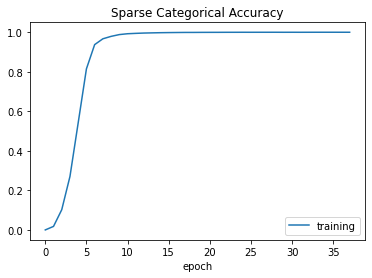

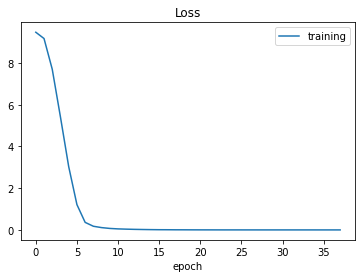

In [15]:
# fold 0: 32
# fold 1: 29
# fold 2: 31
# fold 3: 31
# avg: (32+29+31+31)/4 = 30.75
# total epoch: 30.75 + 30.75*25/100 = 38.4375 = 38

with strategy.scope():
    model = effb3()
    model.compile(
        optimizer = tfa.optimizers.LAMB(LR),
        loss = [tf.keras.losses.SparseCategoricalCrossentropy()],
        metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
    )
model.summary()
    
model.fit(
    train_data, 
    steps_per_epoch=train_size//BATCH_SIZE,
    epochs = 38,
    callbacks=[get_lr_callback()], verbose=1
)

h = model.history
plt_acc(h)
plt_loss(h)

model.save_weights('model_weights.h5')